# MACHINE LEARNING - CONVOLUTIONAL NEURAL NETWORK

## Importing to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Kaggle to Import datasets

In [2]:
!pip install -q kaggle

### Uploading Kaggle API to access datasets

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anoushayzeaghum","key":"5d753216d973453c28b7281d94af2a1b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!cat ~/.kaggle/kaggle.json

{"username":"anoushayzeaghum","key":"5d753216d973453c28b7281d94af2a1b"}

In [6]:
# example
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 343M/346M [00:13<00:00, 29.9MB/s]
100% 346M/346M [00:14<00:00, 25.8MB/s]


In [7]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# copy zipped dataset into your drive
!cp "intel-image-classification.zip" /content/drive/MyDrive/ML_A3

## Importing Libraries

In [10]:
import numpy as np #//This line imports the NumPy library, which is commonly used for numerical operations in Python.
import pandas as pd #  data manipulation and analysis.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # working with images
import seaborn as sns #for statistical data visualization
import warnings
warnings.filterwarnings("ignore") # ignore unnecessary warnings
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import os # a way of interacting with the operating system, such as reading or writing files and directories.
from os import walk #The walk function generates file names in a directory tree by walking through the directory and its subdirectories recursively.
import tensorflow as tf
tf.random.set_seed(0) #This clears the TensorFlow session, releasing any resources held by the previous session. It's useful when you want to release memory after training or defining a model.
tf.keras.backend.clear_session() ##This clears the TensorFlow session, releasing any resources held by the previous session. It's useful when you want to release memory after training or defining a model.

### Defining classes that maps six categories of natural scenes

In [11]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}
dir_train =  "/content/seg_train/seg_train"
dir_test = "/content/seg_test/seg_test"
dir_pred = "/content/seg_pred/seg_pred"

In [12]:
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))#current directory path, subdirectory, file names of prediction
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


## Defining functions for Image Classification

### Function for reading image file names

In [13]:
def read_image_names_class(dpath): #The purpose of the read_image_names_class function is to read and organize image file names based on the class labels of subdirectories within a specified directory. Let's break down the key aspects of its purpose
    fnames = {}
    x, dirnames, y = next(walk(dpath))
    for d in dirnames:
        _,_,temp = next(walk(os.path.join(dpath,d)))
        fnames[classes[d]] = temp

    return dirnames, fnames

### Function for checking class imbalances in a dataset and Plotting images from classes

In [14]:
def sample_images_from_class(nsample, classname, path, fnames):
    sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
    spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]

    return spath

def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))

    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)


### Function for generating predictions

In [15]:
def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:

                spj.append(os.path.join(path, fnames[sp]))

    return spj

def plot_sampled_prediction_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)

    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')


In [16]:
def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))
    return ytrue, ypred

### Function for plotting confusion matrices and preparing images for prediction

In [27]:
def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))

def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')

    parr = tf.keras.preprocessing.image.img_to_array(img)
    tparr = tf.expand_dims(parr, axis=0)

    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]

    sns.barplot(x=x,y=y,ax=ax2)

    return pred

## Checking Distribution Across Test Set of Classes

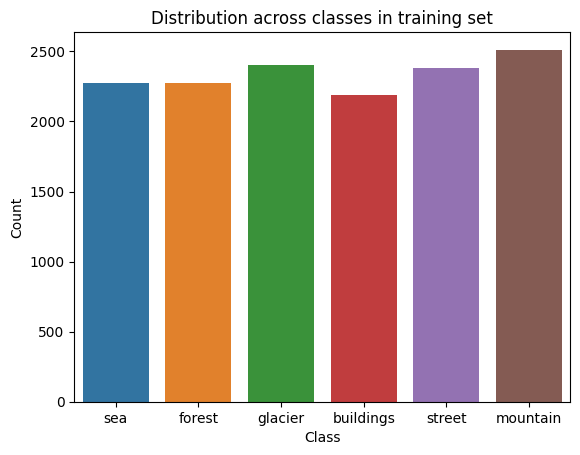

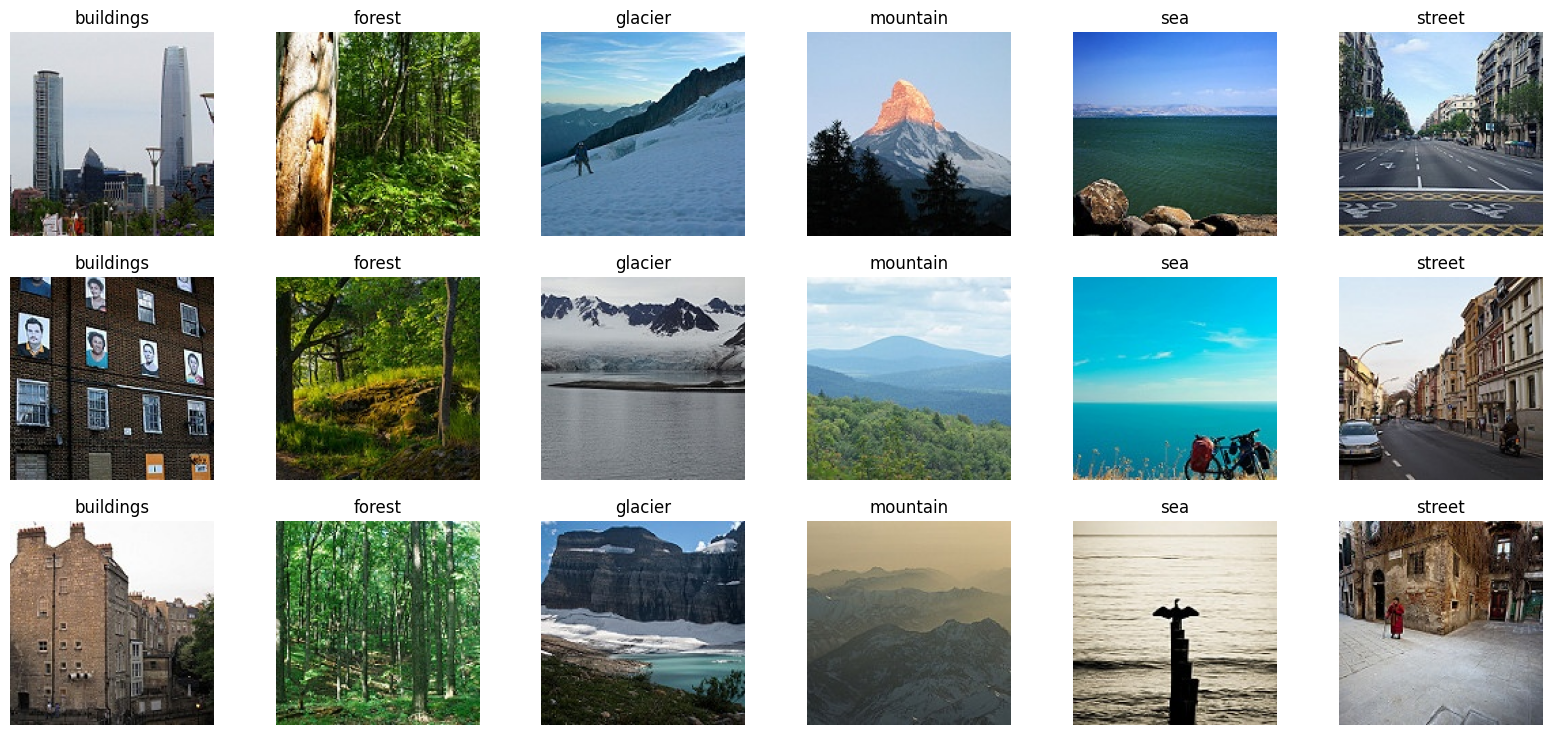

In [57]:
dirnames_train, fnames_train = read_image_names_class(dir_train)
train_summary = check_class_imbalance(fnames_train)
train_summary.head(10)
sns.barplot(data=train_summary, x='Class', y='Count').set_title("Distribution across classes in training set")
plot_sampled_images(dir_train, fnames_train)

## Checking Distribution Across Test Set of Classes

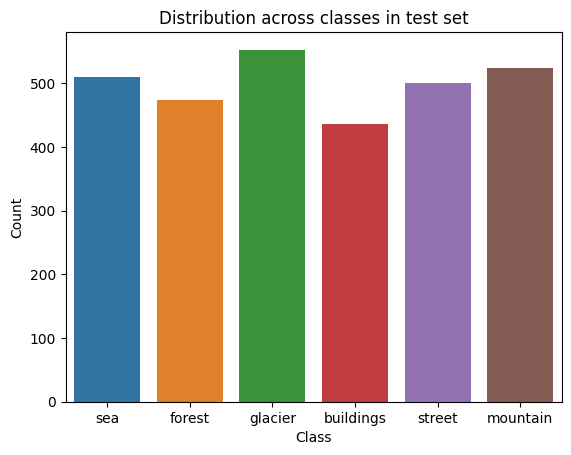

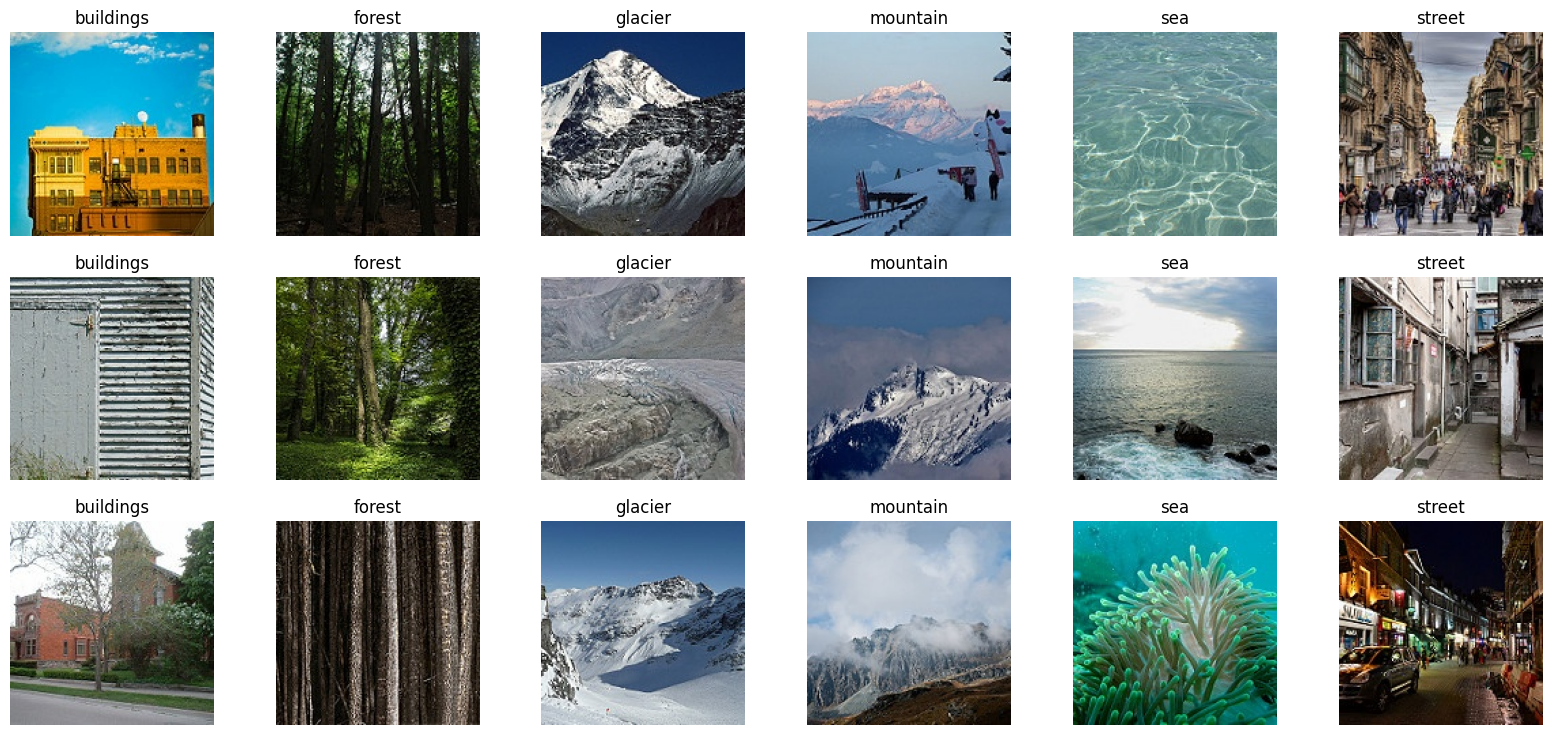

In [34]:
dirnames_test, fnames_test = read_image_names_class(dir_test)
test_summary = check_class_imbalance(fnames_test)
test_summary.head(10)

sns.barplot(data=test_summary, x = 'Class', y='Count').set_title("Distribution across classes in test set")

plot_sampled_images(dir_test, fnames_test)

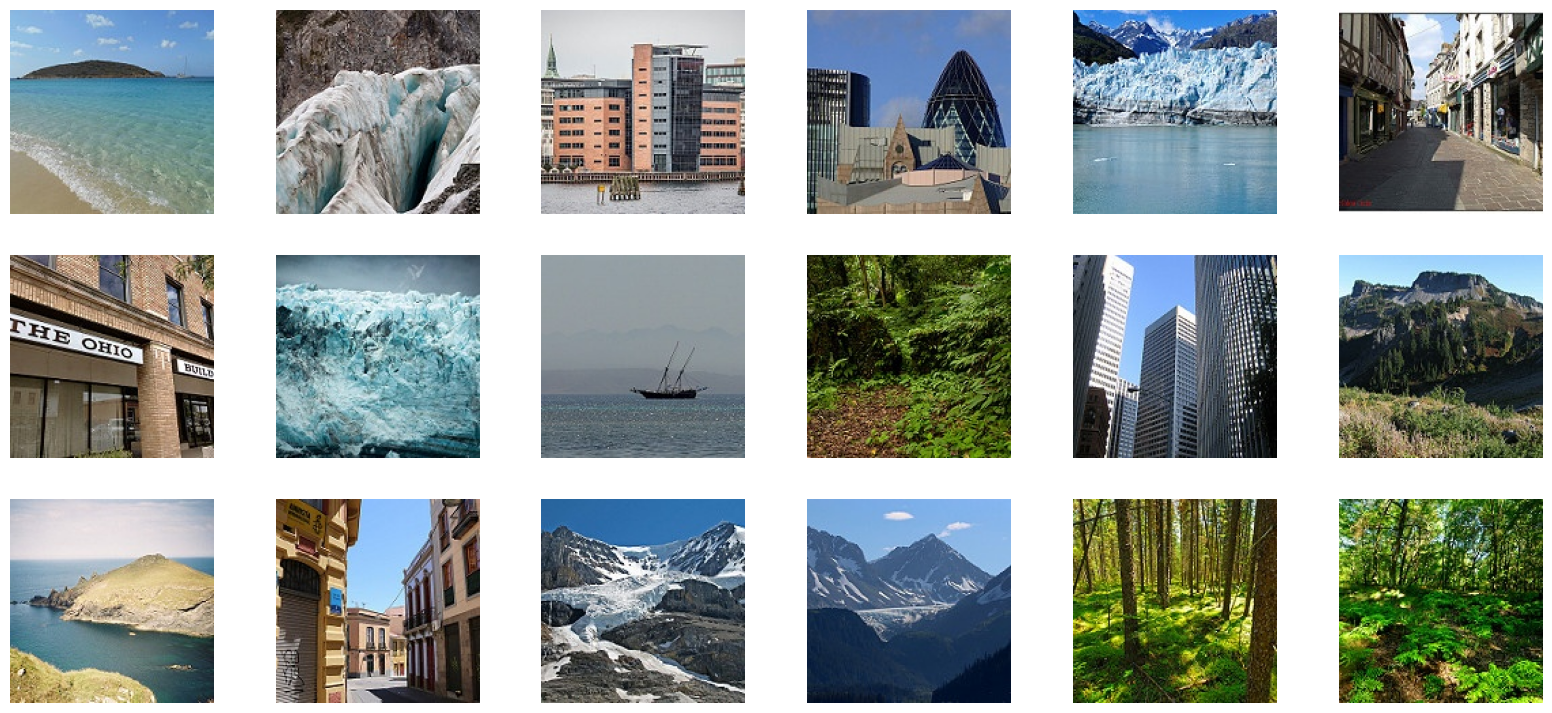

In [35]:
plot_sampled_prediction_images(dir_pred, fnames_pred)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

### Defining Batch Size

In [37]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    "/content/seg_train/seg_train",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Importing Models and Adding Layers

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add more layers as needed

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

## Compiling the Models

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/3
439/439 [==============================] - 506s 1s/step - loss: 1.3069 - accuracy: 0.5975 - val_loss: 1.0091 - val_accuracy: 0.6450
Epoch 2/3
439/439 [==============================] - 500s 1s/step - loss: 0.8381 - accuracy: 0.6908 - val_loss: 0.8956 - val_accuracy: 0.6883
Epoch 3/3
439/439 [==============================] - 501s 1s/step - loss: 0.7446 - accuracy: 0.7279 - val_loss: 0.7750 - val_accuracy: 0.7210


## Model Summary

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 128)               22429824  
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 22431494 (85.57 MB)
Trainable params: 22431494 (85.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [41]:
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 23s 241ms/step - loss: 0.7750 - accuracy: 0.7210
Test accuracy: 0.7210000157356262


### Calculating Loss and Accuracy

In [48]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test set
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes

# Display the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("Confusion Matrix:")
print(conf_mat)

# Display classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, target_names=class_labels))

94/94 [==============================] - 20s 213ms/step - loss: 0.7750 - accuracy: 0.7210
Test Accuracy: 72.10%
Test Loss: 0.7750
94/94 [==============================] - 20s 207ms/step
Confusion Matrix:
[[277  25   8  36  12  79]
 [  5 457   1   6   1   4]
 [ 13   6 323 167  27  17]
 [ 13   9  35 434  28   6]
 [ 40   6  43 127 290   4]
 [ 48  57   3   7   4 382]]
Classification Report:
              precision    recall  f1-score   support

   buildings       0.70      0.63      0.67       437
      forest       0.82      0.96      0.88       474
     glacier       0.78      0.58      0.67       553
    mountain       0.56      0.83      0.67       525
         sea       0.80      0.57      0.67       510
      street       0.78      0.76      0.77       501

    accuracy                           0.72      3000
   macro avg       0.74      0.72      0.72      3000
weighted avg       0.74      0.72      0.72      3000



## Confusion Matrix for Train Data

Found 14034 files belonging to 6 classes.
439/439 [==============================] - 90s 205ms/step - loss: 122.6182 - accuracy: 0.7374


[122.61822509765625, 0.7374234199523926]

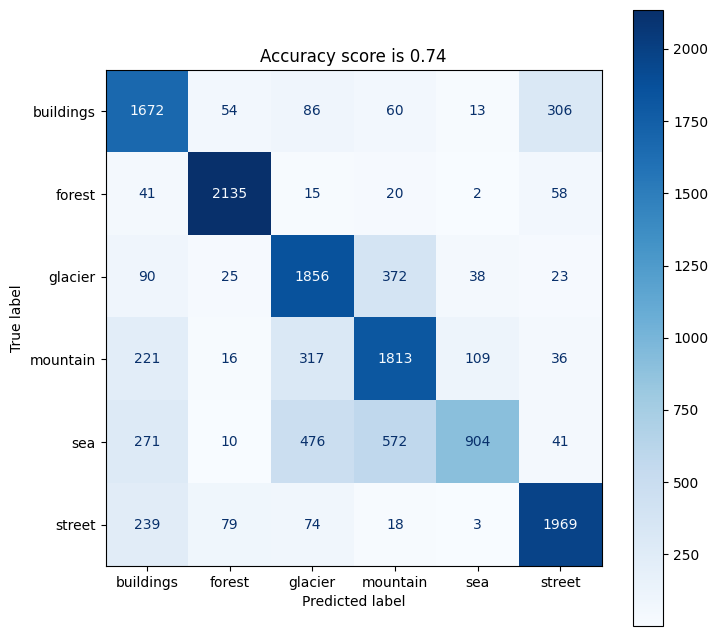

In [52]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch_size, shuffle= False, label_mode='categorical')
y_true, y_pred = get_true_pred(model, train_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(train_ds1)

## Confusion Matrix for Test Data

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 20s 211ms/step - loss: 145.1342 - accuracy: 0.7067


[145.13417053222656, 0.7066666483879089]

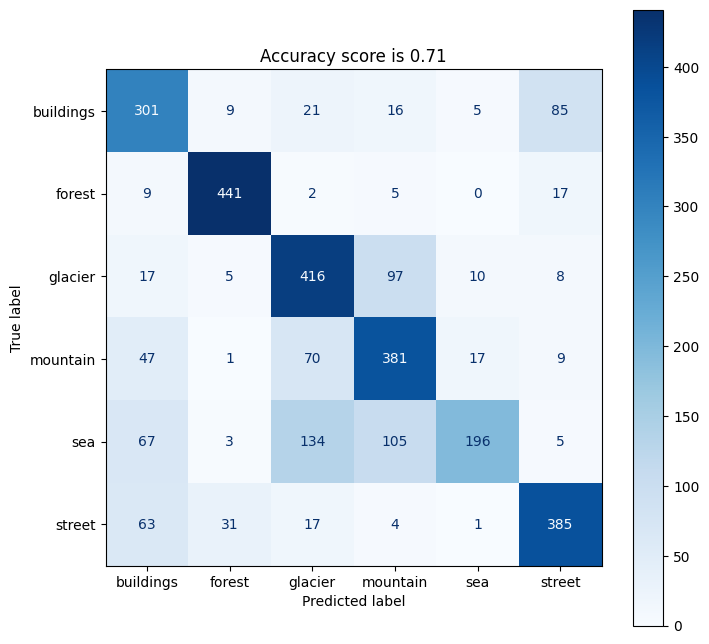

In [53]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch_size, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(model, test_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(test_ds1)

## Plotting Train and Valdation Graphs

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Epoch 1/10
351/351 [==============================] - 332s 933ms/step - loss: 10.7652 - accuracy: 0.3408 - val_loss: 1.7545 - val_accuracy: 0.1981
Epoch 2/10
351/351 [==============================] - 322s 917ms/step - loss: 1.7203 - accuracy: 0.2467 - val_loss: 1.7183 - val_accuracy: 0.3011
Epoch 3/10
351/351 [==============================] - 348s 991ms/step - loss: 1.6136 - accuracy: 0.3052 - val_loss: 1.5424 - val_accuracy: 0.3154
Epoch 4/10
351/351 [==============================] - 324s 922ms/step - loss: 1.6721 - accuracy: 0.2623 - val_loss: 1.8209 - val_accuracy: 0.1728
Epoch 5/10
351/351 [==============================] - 329s 937ms/step - loss: 1.7878 - accuracy: 0.1920 - val_loss: 1.7018 - val_accuracy: 0.2199
Epoch 6/10
351/351 [==============================] - 327s 933ms/step - loss: 1.6709 - accuracy: 0.2662 - val_loss: 1.67

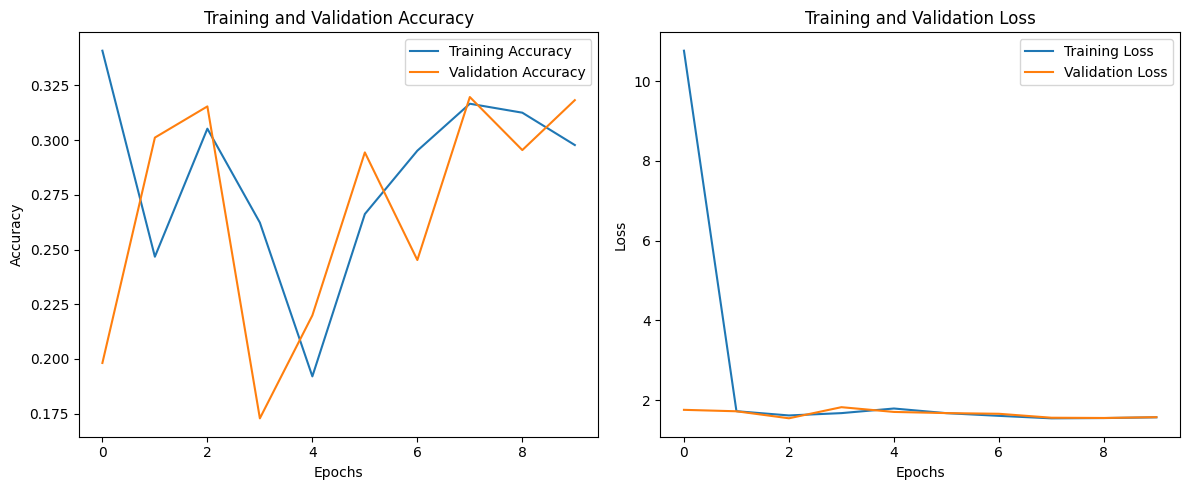

In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming 'model' is already defined and 'dir_train' holds the directory path for training data

# Define batch size and other parameters
batch_size = 32  # Change this value as needed
epochs = 10  # Number of epochs for training

# Load the entire dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=0,
    image_size=(150, 150),
    batch_size=batch_size,
    validation_split=0.2,  # Splitting dataset into training and validation (80-20 split)
    subset="training"  # Indicate to use this portion for training
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=0,
    image_size=(150, 150),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation"  # Indicate to use this portion for validation
)

# Retrieve the number of classes from the dataset
num_classes = len(train_ds.class_names)

# One-hot encode the labels for both training and validation sets
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# Compile the model (if not already compiled)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store training history
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plotting accuracy and loss per epoch
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Training and Validation Accuracy

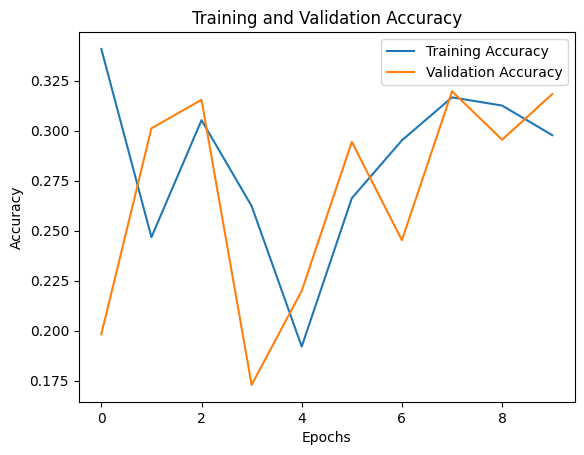

In [60]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

## Training and Validation Loss

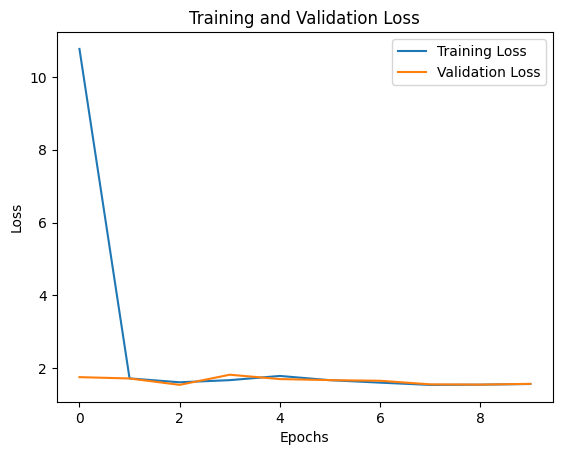

In [61]:
# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()